このデータの扱いについて改善点がありそうな気がする
- クレヒスはある方が良い（uniqueカウント数とか）

In [51]:
import gc

In [18]:
import os
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.externals import joblib
%matplotlib inline
import seaborn as sns

DIR = '~/Desktop'
description = pd.read_csv(os.path.join(DIR,'HomeCredit_columns_description.csv'),encoding = 'latin1')
application = pd.read_csv(os.path.join(DIR, 'application_train.csv'))
bureau = pd.read_csv(os.path.join(DIR, 'bureau.csv'))


In [19]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [20]:
bureau.shape

(1716428, 17)

# Preprocessing
## Solution 3

In [21]:
# 欠損値を確認する
(bureau['AMT_CREDIT_SUM'] == 0).sum()

66582

This shows that imputing with nan with 0 is probably a bad idea

# Feature Engineering
## Solution 3
### Hand crafted features

215354、つまり同一ユーザーが、複数の信用履歴を持っている

In [22]:
bureau[bureau['SK_ID_CURR']==215354]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.00,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.00,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,180000.0,71017.38,108982.62,0.0,Credit card,-31,NaN
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.0,0,42103.8,42103.80,0.00,0.0,Consumer credit,-22,NaN
225157,215354,5714458,Closed,currency 1,-1872,0,-776.0,-1203.0,NaN,0,494550.0,0.00,0.00,0.0,Consumer credit,-696,NaN
225158,215354,5714459,Closed,currency 1,-1734,0,-638.0,-1336.0,NaN,0,1084032.0,0.00,NaN,0.0,Car loan,-1336,NaN
225159,215354,5714460,Closed,currency 1,-1333,0,-1089.0,-987.0,NaN,0,102150.0,NaN,NaN,0.0,Consumer credit,-984,NaN


### First build helper columns

In [23]:
bureau['bureau_credit_active_binary'] = (bureau['CREDIT_ACTIVE'] != 'Closed').astype(int)
bureau['bureau_credit_enddate_binary'] = (bureau['DAYS_CREDIT_ENDDATE'] > 0).astype(int)

groupby_SK_ID_CURR = bureau.groupby(by=['SK_ID_CURR'])

In [24]:
description[description['Row'] == 'DAYS_CREDIT'].Description.tolist()

['How many days before current application did client apply for Credit Bureau credit']

In [25]:
features = pd.DataFrame({'SK_ID_CURR':bureau['SK_ID_CURR'].unique()})
features.head()

,SK_ID_CURR
0,215354
1,162297
2,402440
3,238881
4,222183


In [26]:
features.shape

(305811, 1)

In [28]:
# DAYS_CREDITを何個記録があるか
group_object = groupby_SK_ID_CURR['DAYS_CREDIT'].agg('count').reset_index()
group_object.rename(index=str, columns={'DAYS_CREDIT': 'bureau_number_of_past_loans'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.describe()

,SK_ID_CURR,bureau_number_of_past_loans
count,305811.000000,305811.000000
mean,278047.300091,5.612709
std,102849.568343,4.430354
min,100001.000000,1.000000
25%,188878.500000,2.000000
50%,277895.000000,4.000000
75%,367184.500000,8.000000
max,456255.000000,116.000000


In [29]:
# CREDIT_TYPEについてユニークじゃない数
group_object = groupby_SK_ID_CURR['CREDIT_TYPE'].agg('nunique').reset_index()
group_object.rename(index=str, columns={'CREDIT_TYPE': 'bureau_number_of_loan_types'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types
0,215354,11,3
1,162297,6,3
2,402440,1,1
3,238881,8,2
4,222183,8,3


In [30]:
# 先ほどの２つを割る
features['bureau_average_of_past_loans_per_type'] = \
    features['bureau_number_of_past_loans'] / features['bureau_number_of_loan_types']
    
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type
0,215354,11,3,3.666667
1,162297,6,3,2.000000
2,402440,1,1,1.000000
3,238881,8,2,4.000000
4,222183,8,3,2.666667


In [31]:
# activeなものの平均、クレヒスの中で
group_object = groupby_SK_ID_CURR['bureau_credit_active_binary'].agg('mean').reset_index()

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary
0,215354,11,3,3.666667,0.545455
1,162297,6,3,2.000000,0.500000
2,402440,1,1,1.000000,1.000000
3,238881,8,2,4.000000,0.375000
4,222183,8,3,2.666667,0.625000


In [32]:
# クレヒスの中でどのくらい借りてるかの合計
group_object = groupby_SK_ID_CURR['AMT_CREDIT_SUM_DEBT'].agg('sum').reset_index()
group_object.rename(index=str, columns={'AMT_CREDIT_SUM_DEBT': 'bureau_total_customer_debt'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt
0,215354,11,3,3.666667,0.545455,284463.18
1,162297,6,3,2.000000,0.500000,0.00
2,402440,1,1,1.000000,1.000000,76905.00
3,238881,8,2,4.000000,0.375000,552730.50
4,222183,8,3,2.666667,0.625000,1185081.84


In [33]:
# クレヒスの中のcreditの合計
group_object = groupby_SK_ID_CURR['AMT_CREDIT_SUM'].agg('sum').reset_index()
group_object.rename(index=str, columns={'AMT_CREDIT_SUM': 'bureau_total_customer_credit'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit
0,215354,11,3,3.666667,0.545455,284463.18,5973945.30
1,162297,6,3,2.000000,0.500000,0.00,8230386.15
2,402440,1,1,1.000000,1.000000,76905.00,89910.00
3,238881,8,2,4.000000,0.375000,552730.50,1285239.06
4,222183,8,3,2.666667,0.625000,1185081.84,7158960.00


In [34]:
# 預金でdebtを割る
features['bureau_debt_credit_ratio'] = \
    features['bureau_total_customer_debt'] / features['bureau_total_customer_credit']
    
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit,bureau_debt_credit_ratio
0,215354,11,3,3.666667,0.545455,284463.18,5973945.30,0.047617
1,162297,6,3,2.000000,0.500000,0.00,8230386.15,0.000000
2,402440,1,1,1.000000,1.000000,76905.00,89910.00,0.855355
3,238881,8,2,4.000000,0.375000,552730.50,1285239.06,0.430060
4,222183,8,3,2.666667,0.625000,1185081.84,7158960.00,0.165538


In [35]:
# overdueを足す
group_object = groupby_SK_ID_CURR['AMT_CREDIT_SUM_OVERDUE'].agg('sum').reset_index()
group_object.rename(index=str, columns={'AMT_CREDIT_SUM_OVERDUE': 'bureau_total_customer_overdue'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit,bureau_debt_credit_ratio,bureau_total_customer_overdue
0,215354,11,3,3.666667,0.545455,284463.18,5973945.30,0.047617,0.0
1,162297,6,3,2.000000,0.500000,0.00,8230386.15,0.000000,0.0
2,402440,1,1,1.000000,1.000000,76905.00,89910.00,0.855355,0.0
3,238881,8,2,4.000000,0.375000,552730.50,1285239.06,0.430060,0.0
4,222183,8,3,2.666667,0.625000,1185081.84,7158960.00,0.165538,0.0


In [36]:
# overdueをdebtで割る
features['bureau_overdue_debt_ratio'] = \
    features['bureau_total_customer_overdue'] / features['bureau_total_customer_debt']
    
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit,bureau_debt_credit_ratio,bureau_total_customer_overdue,bureau_overdue_debt_ratio
0,215354,11,3,3.666667,0.545455,284463.18,5973945.30,0.047617,0.0,0.0
1,162297,6,3,2.000000,0.500000,0.00,8230386.15,0.000000,0.0,NaN
2,402440,1,1,1.000000,1.000000,76905.00,89910.00,0.855355,0.0,0.0
3,238881,8,2,4.000000,0.375000,552730.50,1285239.06,0.430060,0.0,0.0
4,222183,8,3,2.666667,0.625000,1185081.84,7158960.00,0.165538,0.0,0.0


In [37]:
group_object = groupby_SK_ID_CURR['CNT_CREDIT_PROLONG'].agg('sum').reset_index()
group_object.rename(index=str, columns={'CNT_CREDIT_PROLONG': 'bureau_average_creditdays_prolonged'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit,bureau_debt_credit_ratio,bureau_total_customer_overdue,bureau_overdue_debt_ratio,bureau_average_creditdays_prolonged
0,215354,11,3,3.666667,0.545455,284463.18,5973945.30,0.047617,0.0,0.0,0
1,162297,6,3,2.000000,0.500000,0.00,8230386.15,0.000000,0.0,NaN,0
2,402440,1,1,1.000000,1.000000,76905.00,89910.00,0.855355,0.0,0.0,0
3,238881,8,2,4.000000,0.375000,552730.50,1285239.06,0.430060,0.0,0.0,0
4,222183,8,3,2.666667,0.625000,1185081.84,7158960.00,0.165538,0.0,0.0,0


In [38]:
# 平均
group_object = groupby_SK_ID_CURR['bureau_credit_enddate_binary'].agg('mean').reset_index()
group_object.rename(index=str, columns={'bureau_credit_enddate_binary': 'bureau_credit_enddate_percentage'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit,bureau_debt_credit_ratio,bureau_total_customer_overdue,bureau_overdue_debt_ratio,bureau_average_creditdays_prolonged,bureau_credit_enddate_percentage
0,215354,11,3,3.666667,0.545455,284463.18,5973945.30,0.047617,0.0,0.0,0,0.454545
1,162297,6,3,2.000000,0.500000,0.00,8230386.15,0.000000,0.0,NaN,0,0.166667
2,402440,1,1,1.000000,1.000000,76905.00,89910.00,0.855355,0.0,0.0,0,1.000000
3,238881,8,2,4.000000,0.375000,552730.50,1285239.06,0.430060,0.0,0.0,0,0.125000
4,222183,8,3,2.666667,0.625000,1185081.84,7158960.00,0.165538,0.0,0.0,0,0.625000


In [61]:
B = bureau[:10000]
grp = B[['SK_ID_CURR', 'SK_ID_BUREAU', 'DAYS_CREDIT']].groupby(by = ['SK_ID_CURR'])
grp1 = grp.apply(lambda x: x.sort_values(['DAYS_CREDIT'], ascending = False)).reset_index(drop = True)#rename(index = str, columns = {'DAYS_CREDIT': 'DAYS_CREDIT_DIFF'})
print("Grouping and Sorting done")
# Calculate Difference between the number of Days 
grp1['DAYS_CREDIT1'] = grp1['DAYS_CREDIT']*-1
grp1['DAYS_DIFF'] = grp1.groupby(by = ['SK_ID_CURR'])['DAYS_CREDIT1'].diff()
grp1['DAYS_DIFF'] = grp1['DAYS_DIFF'].fillna(0).astype('uint32')
del grp1['DAYS_CREDIT1'], grp1['DAYS_CREDIT']
gc.collect()
print("Difference days calculated")

B = B.merge(grp1, on = ['SK_ID_BUREAU'], how = 'left')
print("Difference in Dates between Previous CB applications is CALCULATED ")
B.head()

Grouping and Sorting done
Difference days calculated
Difference in Dates between Previous CB applications is CALCULATED 


,SK_ID_CURR_x,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,bureau_credit_active_binary,bureau_credit_enddate_binary,SK_ID_CURR_y,DAYS_DIFF
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,...,0.0,NaN,0.0,Consumer credit,-131,NaN,0,0,215354,224
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,...,171342.0,NaN,0.0,Credit card,-20,NaN,1,1,215354,5
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,...,NaN,NaN,0.0,Consumer credit,-16,NaN,1,1,215354,160
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,...,NaN,NaN,0.0,Credit card,-16,NaN,1,0,215354,0
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,...,NaN,NaN,0.0,Consumer credit,-21,NaN,1,1,215354,132


In [62]:
grp1.head()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_DIFF
0,100053,5723577,0
1,100053,5723583,3
2,100053,5723582,158
3,100053,5723578,413
4,100053,5723581,301


In [64]:
grp1.groupby(by = ['SK_ID_CURR']).head()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_DIFF
0,100053,5723577,0
1,100053,5723583,3
2,100053,5723582,158
3,100053,5723578,413
4,100053,5723581,301
7,100568,5719893,0
8,100568,5719896,71
9,100568,5719895,1
10,100568,5719897,40
11,100568,5719898,225


In [46]:
group_object = groupby_SK_ID_CURR.apply(lambda x: x.sort_values(['DAYS_CREDIT'], ascending = False)).reset_index(drop = True)

KeyboardInterrupt: 

In [ ]:
group_object.head()

In [ ]:
group_object['DAYS_CREDIT1'] = grp1['DAYS_CREDIT']*-1
group_object['DAYS_DIFF'] = grp1.groupby(by = ['SK_ID_CURR'])['DAYS_CREDIT1'].diff()
group_object['DAYS_DIFF'] = grp1['DAYS_DIFF'].fillna(0).astype('uint32')

In [ ]:
group_object.head()

In [39]:
bureau_ONE = features[features['SK_ID_CURR']==215354]

In [40]:
bureau_ONE

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit,bureau_debt_credit_ratio,bureau_total_customer_overdue,bureau_overdue_debt_ratio,bureau_average_creditdays_prolonged,bureau_credit_enddate_percentage
0,215354,11,3,3.666667,0.545455,284463.18,5973945.3,0.047617,0.0,0.0,0,0.454545


In [41]:
application = application.merge(features,
                                left_on=['SK_ID_CURR'],
                                right_on=['SK_ID_CURR'],
                                how='left',
                                validate='one_to_one')

In [42]:
engineered_numerical_columns = list(features.columns)
engineered_numerical_columns.remove('SK_ID_CURR')
bureau_eng = application[engineered_numerical_columns + ['TARGET']]
bureau_eng_corr = abs(bureau_eng.corr())

In [43]:
bureau_eng_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                                   1.000000
bureau_credit_active_binary              0.079369
bureau_debt_credit_ratio                 0.060235
bureau_credit_enddate_percentage         0.055305
bureau_total_customer_credit             0.014057
bureau_total_customer_overdue            0.013335
bureau_total_customer_debt               0.007144
bureau_average_of_past_loans_per_type    0.006118
bureau_number_of_loan_types              0.004624
bureau_average_creditdays_prolonged      0.004058
bureau_number_of_past_loans              0.004056
bureau_overdue_debt_ratio                0.000939
Name: TARGET, dtype: float64

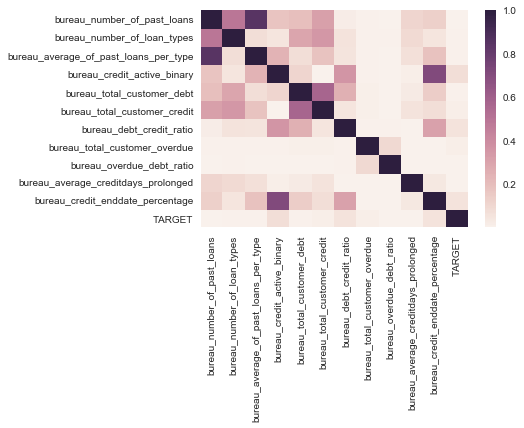

In [45]:
sns.heatmap(bureau_eng_corr)

## Aggregations

In [ ]:
BUREAU_AGGREGATION_RECIPIES = [('CREDIT_TYPE', 'count'),
                               ('CREDIT_ACTIVE', 'size')
                               ]
for agg in ['mean', 'min', 'max', 'sum', 'var']:
    for select in ['AMT_ANNUITY',
                   'AMT_CREDIT_SUM',
                   'AMT_CREDIT_SUM_DEBT',
                   'AMT_CREDIT_SUM_LIMIT',
                   'AMT_CREDIT_SUM_OVERDUE',
                   'AMT_CREDIT_MAX_OVERDUE',
                   'CNT_CREDIT_PROLONG',
                   'CREDIT_DAY_OVERDUE',
                   'DAYS_CREDIT',
                   'DAYS_CREDIT_ENDDATE',
                   'DAYS_CREDIT_UPDATE'
                   ]:
        BUREAU_AGGREGATION_RECIPIES.append((select, agg))
BUREAU_AGGREGATION_RECIPIES = [(['SK_ID_CURR'], BUREAU_AGGREGATION_RECIPIES)]

In [ ]:
groupby_aggregate_names = []
for groupby_cols, specs in tqdm(BUREAU_AGGREGATION_RECIPIES):
    group_object = bureau.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        application = application.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_aggregate_name})
                              [groupby_cols + [groupby_aggregate_name]],
                              on=groupby_cols,
                              how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)

In [ ]:
application.head()

In [ ]:
application_agg = application[groupby_aggregate_names + ['TARGET']]
application_agg_corr = abs(application_agg.corr())

In [ ]:
application_agg_corr.sort_values('TARGET', ascending=False)['TARGET']

# Solution 4
## Hand Crafted Features

In [ ]:
# group = bureau[bureau['bureau_credit_enddate_binary'] == 1].groupby(
#     by=['SK_ID_CURR']).apply(
#     lambda x: x.sort_values(['DAYS_CREDIT_ENDDATE'], ascending=True)).reset_index(drop=True)
# group['bureau_days_enddate_diff'] = group.groupby(by=['SK_ID_CURR'])['DAYS_CREDIT_ENDDATE'].diff()
# group['bureau_days_enddate_diff'] = group['bureau_days_enddate_diff'].fillna(0).astype('uint32')

# bureau = bureau.merge(group[['bureau_days_enddate_diff', 'SK_ID_BUREAU']], on=['SK_ID_BUREAU'], how='left')
# bureau['bureau_average_enddate_future'] = bureau.groupby(
#     by=['SK_ID_CURR'])['bureau_days_enddate_diff'].agg('mean').reset_index()['bureau_days_enddate_diff']

# bureau['bureau_days_credit_diff'] = bureau.groupby(
#     by=['SK_ID_CURR']).apply(
#     lambda x: x.sort_values(['DAYS_CREDIT'], ascending=False)).reset_index(drop=True)['DAYS_CREDIT']
# bureau['bureau_days_credit_diff'] *= -1
# bureau['bureau_days_credit_diff'] = bureau.groupby(by=['SK_ID_CURR'])['bureau_days_credit_diff'].diff()
# bureau['bureau_days_credit_diff'] = bureau['bureau_days_credit_diff'].fillna(0)